In [42]:
from pathlib import Path 
# from POptAcq.models.gp import TanimotoGP
from scipy.stats import multivariate_normal
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from gp import TanimotoGP, fit_gp_hyperparameters
import torch
import numpy as np 
import pandas as pd 
import random 
import json 
import copy 

# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="3"

### Settings 

In [43]:
dataset = 'qm9'
datafile = Path('data') / f'{dataset}.csv'
objective = 'gap' # 'ESOL predicted log solubility in mols per litre'
c = 1 # maximize 
gpu = True 

n_iter = 20
batch_size = 100
initial_batch_size = 100
methods = ['mean', 'ours', 'ts', 'ucb']
random_seeds = range(10)

res_dir = Path('bo_results_gpytorch')
res_dir.mkdir(exist_ok=True)

### Functions

#### Acquisition functions 

In [44]:
def acquire(method, smiles, model, featurizer, c: int = 1, batch_size: int = 100, **kwargs):
    acq_functions = {
        'mean': acquire_mean, 
        'ucb': acquire_ucb, 
        'ours': acquire_ours, 
        'ts': acquire_ts
    }
    if ( method == 'ours' or method == 'ts' ) and len(smiles) > 5000: 
        smiles_filtered = acq_functions['mean'](smiles, model, featurizer, c, batch_size=5000, **kwargs)
        return acq_functions[method](smiles_filtered, model, featurizer, c, batch_size, **kwargs)
    
    return acq_functions[method](smiles, model, featurizer, c, batch_size, **kwargs)

def mean_cov_from_gp(model: TanimotoGP, smiles: list, featurizer: dict, full_cov: bool = True): 
    model.eval()
    model.likelihood.eval()
    X_test = np.array([featurizer[smi] for smi in smiles])
    if gpu: 
        f_preds = model.likelihood(model(torch.as_tensor(X_test).cuda()))
        if full_cov: 
            return f_preds.mean.cpu().detach().numpy(), f_preds.covariance_matrix.cpu().detach().numpy()
        return f_preds.mean.cpu().detach().numpy(), f_preds.variance.cpu().detach().numpy()

    f_preds = model.likelihood(model(torch.as_tensor(X_test)))
    if full_cov: 
        # mean, cov = model.model.posterior().predict_f(X_test, full_cov=True)
        return f_preds.mean.detach().numpy(), f_preds.covariance_matrix.detach().numpy()
    # mean, var = model.model.posterior().predict_f(X_test, full_cov=False)
    return f_preds.mean.detach().numpy(), f_preds.variance.detach().numpy() # np.squeeze(mean.numpy()), np.squeeze(var.numpy())

def acquire_mean(smiles, model, featurizer, c: int = 1, batch_size: int = 100, **kwargs): 
    mean, _ = mean_cov_from_gp(smiles=smiles, model=model, featurizer=featurizer, full_cov=False)
    acquisition_scores = {smi: score for smi, score in zip(smiles, c*mean)}
    sorted_smis = sorted(smiles, key=lambda smi: -1*acquisition_scores[smi])
    return sorted_smis[:batch_size]

def acquire_ucb(smiles, model, featurizer, c: int = 1, batch_size: int = 100, beta: float = 1, **kwargs): 
    mean, var = mean_cov_from_gp(smiles=smiles, model=model, featurizer=featurizer, full_cov=False)
    acquisition_scores = {smi: score for smi, score in zip(smiles, c*mean + beta*np.sqrt(var))}
    sorted_smis = sorted(smiles, key=lambda smi: -1*acquisition_scores[smi])
    return sorted_smis[:batch_size]

def acquire_ours(smiles, model, featurizer, c: int = 1, batch_size: int = 100, Ns: int = 10000, seed: int = None, **kwargs): 
    mean, cov = mean_cov_from_gp(smiles=smiles, model=model, featurizer=featurizer, full_cov=True)
    p_yx = multivariate_normal(mean=mean, cov=cov, allow_singular=True)
    samples = p_yx.rvs(size=Ns, random_state=seed)
    top_samples = np.array([np.argmax(c*sample) for sample in samples])
    probs = np.bincount(top_samples, minlength=len(mean))/Ns # [np.sum(top_k_samples==i)/N_samples for i in range(samples.shape[1])]
    acquisition_scores = {smi: (-1*prob, -1*mean) for smi, prob, mean in zip(smiles, probs, mean)} # for equal probs, use mean for sorting 
    sorted_smis = sorted(smiles, key=lambda smi: acquisition_scores[smi] )
    return sorted_smis[:batch_size]

def acquire_ts(smiles, model, featurizer, c: int = 1, batch_size: int = 100, seed: int = None, **kwargs): 
    mean, cov = mean_cov_from_gp(smiles=smiles, model=model, featurizer=featurizer, full_cov=True)
    p_yx = multivariate_normal(mean=mean, cov=cov, allow_singular=True)
    samples = p_yx.rvs(size=batch_size, random_state=seed)

    selected_inds = []

    for sample in samples:
        for ind in np.argsort(c*sample)[::-1]:            
            if ind not in selected_inds: 
                selected_inds.append(ind)
                break 

    selected_smis = [smiles[i] for i in selected_inds]

    return selected_smis

#### Featurizer 

In [45]:
def smiles_to_fingerprint_arr(
    smiles_list: list[str],
    radius: int = 3, 
    fpSize: int = 2048,
) -> np.array:
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=fpSize)
    mols = [Chem.MolFromSmiles(s) for s in smiles_list]
    fps = [mfpgen.GetCountFingerprintAsNumPy(m) for m in mols]
    return np.asarray(fps, dtype=float)

def fp_featurizer(smiles_list): 
    fps = smiles_to_fingerprint_arr(smiles_list)
    featurizer = {
        smi: fps[i,:]
        for i, smi in enumerate(smiles_list)
    }
    return featurizer

#### Misc

In [46]:
def update_acquired(acquired_data, unacquired_smiles: set, selected_smiles, test_data): 
    for smi in selected_smiles: 
        unacquired_smiles.remove(smi)
        acquired_data[smi] = test_data[smi]
    
    return acquired_data, unacquired_smiles

def train_model(acquired_data, featurizer): 
    X_train = np.array([featurizer[smi] for smi in acquired_data])
    y_train = np.array(list(acquired_data.values()))
    if gpu: 
        model = TanimotoGP(
            train_x=torch.as_tensor(X_train).cuda(), train_y=torch.as_tensor(y_train).cuda()
        ).cuda()
    else: 
        model = TanimotoGP(
            train_x=torch.as_tensor(X_train), train_y=torch.as_tensor(y_train)
        )        
    fit_gp_hyperparameters(model)
    # model.train(xs=X_train, ys=y_train)
    return model

### Run 

In [47]:
# load data, initialize data storage objects 
all_data = pd.read_csv(datafile)
acquired_data = {}
all_smiles = list(all_data['smiles'])
featurizer = fp_featurizer(all_smiles)
storage = []
acquired_data = {} # dictionary mapping smiles to score 
unacquired_smiles = list(set(all_smiles)) # set of unacquired smiles 
test_data = {smi: score for smi, score in zip(all_smiles, all_data[objective])}
# model = TanimotoGP()

In [48]:
storage = []

for rs in random_seeds: 
    for method in methods: 

        # initialize 
        acquired_data = {}
        unacquired_smiles = list(set(all_smiles))

        random.seed(rs)

        # get initial batch 
        selected_smiles = random.sample(sorted(unacquired_smiles), initial_batch_size)
        acquired_data, unacquired_smiles = update_acquired(acquired_data, unacquired_smiles, selected_smiles, test_data)

        # update storage 
        acq_vals = sorted([c*s for s in acquired_data.values()])
        top_aves = {f'Top {k} ave': np.mean(acq_vals[-1*k:]) for k in [1, 10, 50, 100]}
        storage.append({**{
            'Method': method, 
            'Iteration': 0,
            'All acquired points': copy.deepcopy(acquired_data),
            'New acquired points': {smi: acquired_data[smi] for smi in selected_smiles},
            'Random seed': rs
        }, **top_aves})

        # train model
        model = train_model(acquired_data, featurizer)

        # print
        acq_vals = sorted(acquired_data.values())
        print(f'METHOD: {method}, SEED: {rs}')
        print(f'\t Iter 0 -- top 1: {max(acq_vals):0.2f}, top 10 ave: {np.mean(acq_vals[-10:]):0.2f}, top 50 ave: {np.mean(acq_vals[-50:]):0.2f}')
        
        for iter in range(1, n_iter+1): 
            # acquire 
            selected_smiles = acquire(
                method=method, smiles=unacquired_smiles, model=model, featurizer=featurizer, batch_size=batch_size,
            ) 

            # get actual scores and update list of acquired data and unacquired smiles 
            acquired_data, unacquired_smiles = update_acquired(acquired_data, unacquired_smiles, selected_smiles, test_data)

            # update storage 
            acq_vals = sorted([c*s for s in acquired_data.values()])
            top_aves = {f'Top {k} ave': np.mean(acq_vals[-1*k:]) for k in [1, 10, 50, 100]}
            storage.append({**{
                'Method': method, 
                'Iteration': iter,
                'All acquired points': copy.deepcopy(acquired_data),
                'New acquired points': {smi: acquired_data[smi] for smi in selected_smiles},
                'Random seed': rs
            }, **top_aves})

            # train model 
            model = train_model(acquired_data, featurizer)

            # print an update
            print(f'\t Iter {iter} -- top 1: {max(acq_vals):0.2f}, top 10 ave: {np.mean(acq_vals[-10:]):0.2f}, top 50 ave: {np.mean(acq_vals[-50:]):0.2f}')


    with open(res_dir / f'{dataset}_{objective}_batch_{batch_size}_initbatch_{initial_batch_size}_results.json', 'w') as f: 
        json.dump(storage, f, indent='\t')


METHOD: mean, SEED: 0
	 Iter 0 -- top 1: 0.68, top 10 ave: -0.92, top 50 ave: -2.85
	 Iter 1 -- top 1: 0.83, top 10 ave: 0.60, top 50 ave: -0.59
	 Iter 2 -- top 1: 1.07, top 10 ave: 0.69, top 50 ave: -0.11
	 Iter 3 -- top 1: 1.09, top 10 ave: 0.75, top 50 ave: 0.10
	 Iter 4 -- top 1: 1.09, top 10 ave: 0.78, top 50 ave: 0.15
	 Iter 5 -- top 1: 1.09, top 10 ave: 0.78, top 50 ave: 0.15
	 Iter 6 -- top 1: 1.09, top 10 ave: 0.78, top 50 ave: 0.15
	 Iter 7 -- top 1: 1.09, top 10 ave: 0.78, top 50 ave: 0.15


	 Iter 8 -- top 1: 1.09, top 10 ave: 0.78, top 50 ave: 0.15
	 Iter 9 -- top 1: 1.09, top 10 ave: 0.78, top 50 ave: 0.15
	 Iter 10 -- top 1: 1.09, top 10 ave: 0.78, top 50 ave: 0.15
METHOD: ours, SEED: 0
	 Iter 0 -- top 1: 0.68, top 10 ave: -0.92, top 50 ave: -2.85
	 Iter 1 -- top 1: 0.83, top 10 ave: 0.61, top 50 ave: -0.41
	 Iter 2 -- top 1: 1.09, top 10 ave: 0.75, top 50 ave: 0.07
	 Iter 3 -- top 1: 1.09, top 10 ave: 0.78, top 50 ave: 0.15
	 Iter 4 -- top 1: 1.09, top 10 ave: 0.78, top 50 ave: 0.15
	 Iter 5 -- top 1: 1.09, top 10 ave: 0.78, top 50 ave: 0.15
	 Iter 6 -- top 1: 1.09, top 10 ave: 0.78, top 50 ave: 0.15
	 Iter 7 -- top 1: 1.09, top 10 ave: 0.78, top 50 ave: 0.15
	 Iter 8 -- top 1: 1.09, top 10 ave: 0.78, top 50 ave: 0.15
	 Iter 9 -- top 1: 1.09, top 10 ave: 0.78, top 50 ave: 0.15
	 Iter 10 -- top 1: 1.09, top 10 ave: 0.78, top 50 ave: 0.15
METHOD: ts, SEED: 0
	 Iter 0 -- top 1: 0.68, top 10 ave: -0.92, top 50 ave: -2.85
	 Iter 1 -- top 1: 0.83, top 10 ave: 0.62, top 50 a

### Visualize results 

In [49]:
import seaborn as sns 
import matplotlib.pyplot as plt

f'{dataset}_{objective}_batch_{batch_size}_initbatch_{initial_batch_size}_results.json'

'delaney-processed_ESOL predicted log solubility in mols per litre_batch_50_initbatch_50_results.json'

Load back data 

In [50]:
with open(res_dir / f'{dataset}_{objective}_batch_{batch_size}_initbatch_{initial_batch_size}_results.json', 'r') as f: 
    storage = json.load(f)

# load data, initialize data storage objects 
all_data = pd.read_csv(datafile)
all_smiles = list(all_data['smiles'])
test_data = {smi: score for smi, score in zip(all_smiles, all_data[objective])}

#### Average top k score 

In [51]:
# only focus on top k (remove everything else from dictionary)
data = []
for entry in storage: 
    data.append({
        key: entry[key] for key in entry.keys()
        if not key.endswith('points')
    })

data_df = pd.DataFrame(data)

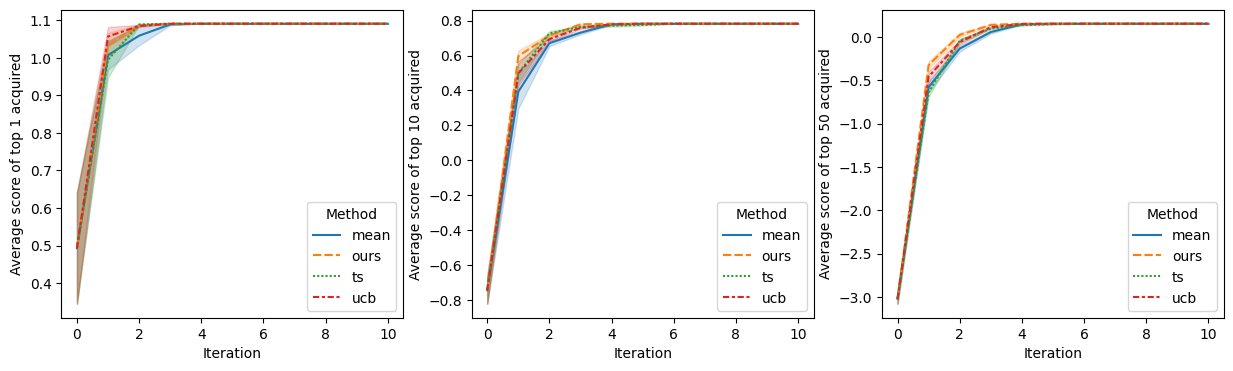

In [52]:
fig, axs = plt.subplots(1,3, )
for ax, k in zip(axs, [1, 10, 50]):
    sns.lineplot(data=data_df, x='Iteration', y=f'Top {k} ave', hue='Method', style='Method', ax=ax, errorbar=('se',1))
    ax.set_ylabel(f'Average score of top {k} acquired')

fig.set_figheight(4)
fig.set_figwidth(15)


#### Fraction of true top k 

In [53]:
k = [0.01, 0.05, 0.1]
kN = [int(np.ceil(kk*len(test_data))) for kk in k]
top_smis = {kk: set(sorted(list(test_data), key = lambda smi: -1*c*test_data[smi])[:kk]) for kk in kN}

data_top_k = []
for entry in storage: 
    # acq_smis_all = set(entry["All acquired points"].keys())
    # frac_top_k = len(top_smis.intersection(acq_smis_all))/kN
    data_top_k.append({**{
        key: entry[key] for key in entry.keys()
        if not key.endswith('points')
    }, **{
        f'Fraction top {100*kk:0.1f}%': len(top_smis[kkN].intersection(set(entry["All acquired points"].keys())))/kkN
        for kkN, kk in zip(kN, k)
    }})

data_df_top_k = pd.DataFrame(data_top_k)


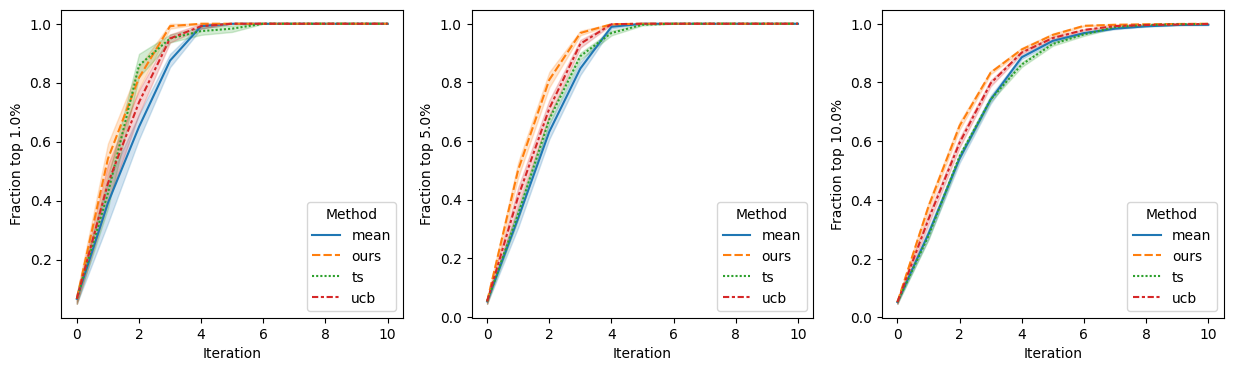

In [54]:
fig, axs = plt.subplots(1,3, )
for ax, kk, kkN in zip(axs, k, kN):
    sns.lineplot(data=data_df_top_k, x='Iteration', y=f'Fraction top {100*kk:0.1f}%', hue='Method', style='Method', ax=ax, errorbar=("se", 1))

    # theo_max = [min(kkN, (i+1)*batch_size)/kkN for i in range(n_iter+1)]
    # sns.lineplot(x=range(n_iter+1), y=theo_max, c='k', ax=ax, legend=False)

fig.set_figheight(4)
fig.set_figwidth(15)